# Cross-Filter PSF Matching

**Use case:** Measure galaxy photometry in an extragalactic "blank" field. Related to [JDox Science Use Case #22](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-example-science-programs/nircam-deep-field-imaging-with-miri-imaging-parallels).<br>
**Data:** JWST simulated NIRCam images from [JADES JWST GTO extragalactic blank field](http://fenrir.as.arizona.edu/jwstmock/).<br>
(Williams et al. 2018) https://ui.adsabs.harvard.edu/abs/2018ApJS..236...33W.<br>
**Tools:**  photutils, matplotlib.<br>
**Cross-intrument:** potentially NIRISS, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction
 
This notebook uses `photutils` to detect objects/galaxies in NIRCam deep imaging.  Detections are first made in a F200W image, then isophotal photometry is obtained in all 9 filters (F090W, F115W, F150W, F200W, F277W, F335M, F356W, F410M, F444W). PSF-matching is used to correct photometry measured in the Long Wavelength images (redder than F200W). 

After saving the photometry catalog, the notebook demonstrates how one would load the notebook in a new session. 
It demonstrates some simple analysis of the full catalog and on an individual galaxy. 
By comparing the measured colors to simulated input colors,
it shows the measurements are more accurate after PSF corrections, though they could be improved further.

The notebook analyzes only the central 1000 x 1000 pixels (30" x 30") of the full JADES simulation. These cutouts have been staged at STScI with permission from the authors (Williams et al.).

**NOTES:** 
* This is a work in progress. More accurate photometry may be obtainable.

* These JADES images are simulated using [Guitarra](https://github.com/cnaw/guitarra),
not [MIRAGE](https://github.com/spacetelescope/mirage).
They have different properties and units (e-/s) than JWST pipeline products (MJy/sr).

* All images are aligned to the same 0.03" pixel grid prior to analysis. This alignment can be done using [`reproject`](https://reproject.readthedocs.io), if needed.

* The flux uncertainty calculations could be improved further by accounting for correlated noise and/or measuring the noise in each image more directly.

*Developer's Note:*  

Summary of issues reported below:
* units work with `plot` but are incompatible with `errorbar` and `text`
* flux units can be automatically converted to AB magnitudes, 
but flux *uncertainties* cannot be automatically converted to magnitude uncertainties
* secondary axis should automatically handle conversion between flux and AB magnitude units
* `sharex` and `sharey` don't work with WCS `projection`

And I couldn't figure out how to:  
* Make plot axes autoscale to only *some* of plotted data
* Make tooltips hover over data points under cursor in interactive plot


In [1]:
# Check PEP 8 style formatting
# %load_ext pycodestyle_magic
# %flake8_on --ignore E261,E501,W291,W2,E302,E305

## Import packages

* Numpy for general array computations
* Photutils for photometry calculations, PSF matching
* Astropy for FITS, WCS, tables, units, color images, plotting, convolution
* os and glob for file management
* copy for table modfications
* Matplotlib for plotting
* Watermark to check versions of all imports (optional)

In [2]:
import numpy as np
import os
from glob import glob
from copy import deepcopy

import astropy  # version 4.2 is required to write magnitudes to ecsv file
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (detect_sources, deblend_sources, SourceCatalog, 
                                    make_2dgaussian_kernel, SegmentationImage)
from photutils.utils import calc_total_error

from photutils.psf.matching import resize_psf, SplitCosineBellWindow, create_matching_kernel
from astropy.convolution import convolve, convolve_fft # , Gaussian2DKernel, Tophat2DKernel

### Matplotlib setup for plotting
There are two versions
 - `notebook` -- gives interactive plots, but makes the overall notebook a bit harder to scroll
 - `inline` -- gives non-interactive plots for better overall scrolling

*Developer's Notes:*

    `%matplotlib notebook` occasionally creates oversized plot; need to rerun cell to get it to settle back down

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version if you want interactive plots
# %matplotlib notebook

import matplotlib.ticker as ticker
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100

import mplcursors  # optional to hover over plotted points and reveal ID number

In [4]:
# Show versions of Python and imported libraries
try:
    import watermark
    %load_ext watermark
    # %watermark -n -v -m -g -iv
    %watermark -iv -v
except ImportError:
    pass

### Create list of images to be loaded and analyzed

All data and weight images must be aligned to the same pixel grid. 
(If needed, use [`reproject`](https://reproject.readthedocs.io) to do so.)

In [5]:
input_file_url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/'

filters = 'F090W F115W F150W F200W F277W F335M F356W F410M F444W'.split()
wavelengths = np.array([int(filt[1:4]) / 100 for filt in filters]) * u.um  # e.g., F115W = 1.15 microns

# Data images [e-/s], unlike JWST pipeline images that will have units [Myr/sr]
image_files = {}
for filt in filters:
    filename = f'jades_jwst_nircam_goods_s_crop_{filt}.fits'
    image_files[filt] = os.path.join(input_file_url, filename)

# Weight images (Inverse Variance Maps; IVM)
weight_files = {}
for filt in filters:
    filename = f'jades_jwst_nircam_goods_s_crop_{filt}_wht.fits'
    weight_files[filt] = os.path.join(input_file_url, filename)

### Load detection image: F200W

In [6]:
detection_filter = filt = 'F200W'
infile = image_files[filt]
hdu = fits.open(infile)
data = hdu[0].data
imwcs = wcs.WCS(hdu[0].header, hdu)

weight = fits.open(weight_files[filt])[0].data

### Report image size and field of view

In [7]:
ny, nx = data.shape
# image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
outline = '%d x %d pixels' % (ny, nx)
outline += ' = %g" x %g"' % (ny * image_pixel_scale, nx * image_pixel_scale)
outline += ' (%.2f" / pixel)' % image_pixel_scale
print(outline)

1000 x 1000 pixels = 30" x 30" (0.03" / pixel)


### Create color images (optional)

In [8]:
# 3 NIRCam short wavelength channel images
r = fits.open(image_files['F200W'])[0].data
g = fits.open(image_files['F150W'])[0].data
b = fits.open(image_files['F090W'])[0].data
color_image_short_wavelength = make_lupton_rgb(r, g, b, Q=5, stretch=0.02) # , minimum=-0.001

In [9]:
# 3 NIRCam long wavelength channel images
r = fits.open(image_files['F444W'])[0].data
g = fits.open(image_files['F356W'])[0].data
b = fits.open(image_files['F277W'])[0].data

color_image_long_wavelength = make_lupton_rgb(r, g, b, Q=5, stretch=0.02) # , minimum=-0.001

*Developer's Note:*

    sharex & sharey appear to have some compatibility issues with projection=imwcs

    As a workaround, I tried but was unable to turn off yticklabels in the right plot below

Interactive zoom / pan controls both images simultaneously


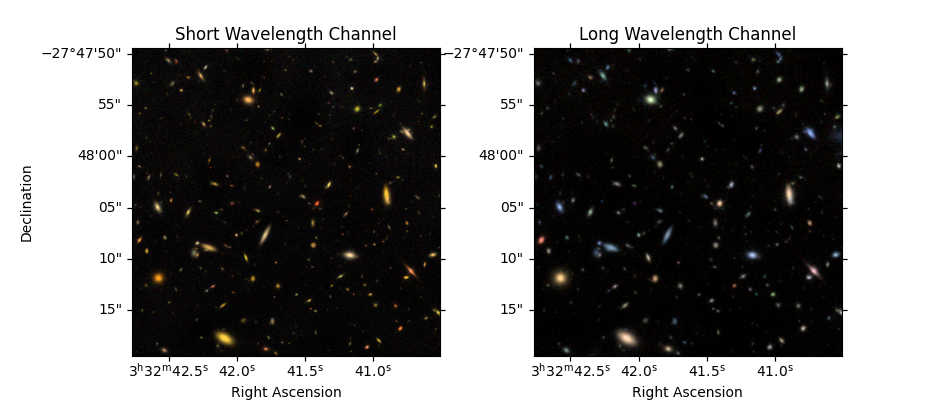

In [10]:
fig = plt.figure(figsize=(9.5, 4))

ax_sw = fig.add_subplot(1, 2, 1, projection=imwcs) # , sharex=True, sharey=True)
ax_sw.imshow(color_image_short_wavelength, origin='lower')
ax_sw.set_xlabel('Right Ascension')
ax_sw.set_ylabel('Declination')
ax_sw.set_title('Short Wavelength Channel')

ax_lw = fig.add_subplot(1, 2, 2, projection=imwcs, sharex=ax_sw, sharey=ax_sw)
ax_lw.imshow(color_image_long_wavelength, origin='lower')
ax_lw.set_xlabel('Right Ascension')
ax_lw.set_title('Long Wavelength Channel')
ax_lw.set_ylabel('')
# ax_lw.set(yticklabels=[])  # this didn't work

# plt.subplots_adjust(left=0.15)
print('Interactive zoom / pan controls both images simultaneously')

### Detect Sources and Deblend using astropy.photutils
https://photutils.readthedocs.io/en/latest/segmentation.html

In [11]:
# Define all detection and measurement parameters here so that we do measurements consistently for every image

class Photutils_Catalog:
    def __init__(self, filt, image_file=None, verbose=True):
        self.image_file = image_file or image_files[filt]
        self.hdu = fits.open(self.image_file)
        self.data = self.hdu[0].data
        self.imwcs = wcs.WCS(self.hdu[0].header, self.hdu)
        self.zeropoint = self.hdu[0].header['ABMAG'] * u.ABmag
        self.weight_file = weight_files[filt]
        self.weight = fits.open(weight_files[filt])[0].data
        if verbose:
            print(filt, '  zeropoint =', self.zeropoint)
            print(self.image_file)
            print(self.weight_file)
        
    def measure_background_map(self, bkg_size=50, filter_size=3, verbose=True):
        # Calculate sigma-clipped background in cells of 50x50 pixels, then median filter over 3x3 cells
        # For best results, the image should span an integer number of cells in both dimensions (here, 1000=20x50 pixels)
        # https://photutils.readthedocs.io/en/stable/background.html
        self.background_map = Background2D(self.data, bkg_size, filter_size=filter_size)

    def run_detect_sources(self, nsigma, npixels, smooth_fwhm=2, kernel_size=5, 
                           deblend_levels=32, deblend_contrast=0.001, verbose=True):

        # Set detection threshold map as nsigma times RMS above background pedestal
        detection_threshold = (nsigma * self.background_map.background_rms) + self.background_map.background

        # Before detection, convolve data with Gaussian
        smooth_kernel = make_2dgaussian_kernel(smooth_fwhm, size=kernel_size)
        convolved_data = convolve(self.data, smooth_kernel)

        # Detect sources with npixels connected pixels at/above threshold in data smoothed by kernel
        # https://photutils.readthedocs.io/en/stable/segmentation.html
        self.segm_detect = detect_sources(convolved_data, detection_threshold, npixels=npixels)

        # Deblend: separate connected/overlapping sources
        # https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending
        self.segm_deblend = deblend_sources(convolved_data, self.segm_detect, npixels=npixels,
                                            nlevels=deblend_levels, contrast=deblend_contrast)
        if verbose:
            output = 'Cataloged %d objects' % self.segm_deblend.nlabels
            output += ', deblended from %d detections' % self.segm_detect.nlabels
            median_threshold = (nsigma * self.background_map.background_rms_median) \
                + self.background_map.background_median
            output += ' with %d pixels above %g-sigma threshold' % (npixels, nsigma)
            # Background outputs equivalent to those reported by SourceExtractor
            output += '\n'
            output += 'Background median %g' % self.background_map.background_median
            output += ', RMS %g' % self.background_map.background_rms_median
            output += ', threshold median %g' % median_threshold
            print(output)

    def measure_source_properties(self, exposure_time, local_background_width=24):
        # "effective_gain" = exposure time map (conversion from data rate units to counts)
        # weight = inverse variance map = 1 / sigma_background**2 (without sources)
        # https://photutils.readthedocs.io/en/latest/api/photutils.utils.calc_total_error.html
        self.exposure_time_map = exposure_time * self.background_map.background_rms_median**2 * self.weight

        # Data RMS uncertainty is combination of background RMS and source Poisson uncertainties
        background_rms = 1 / np.sqrt(self.weight)
        # effective gain parameter required to be positive everywhere (not zero), so adding small value 1e-8
        self.data_rms = calc_total_error(self.data, background_rms, self.exposure_time_map+1e-8)

        self.catalog = SourceCatalog(self.data-self.background_map.background, self.segm_deblend, wcs=self.imwcs, 
                                         error=self.data_rms, background=self.background_map.background, 
                                         localbkg_width=local_background_width)

In [12]:
detection_catalog = Photutils_Catalog(detection_filter)
detection_catalog.measure_background_map()
detection_catalog.run_detect_sources(nsigma=2, npixels=5)

F200W   zeropoint = 27.9973 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F200W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F200W_wht.fits


Cataloged 320 objects, deblended from 299 detections with 5 pixels above 2-sigma threshold
Background median 6.25759e-06, RMS 0.00187681, threshold median 0.00375987


### Measure photometry (and more) in detection image
https://photutils.readthedocs.io/en/latest/segmentation.html#centroids-photometry-and-morphological-properties

In [13]:
# exposure_time = hdu[0].header.get('EXPTIME')  # seconds
exposure_time = 49500  # seconds; Adding by hand because it's missing from the image header
detection_catalog.measure_source_properties(exposure_time)

In [14]:
# Save segmentation map of detected objects
segm_hdu = fits.PrimaryHDU(detection_catalog.segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
segm_hdu.writeto('JADES_detections_segm.fits', overwrite=True)

### Show detections alongside images (optional)

*Developer's Note:*

    Interactive plots zoom / pan all frames simultaneously. (User can zoom in on individual galaxies.)

Interactive zoom / pan controls all images simultaneously


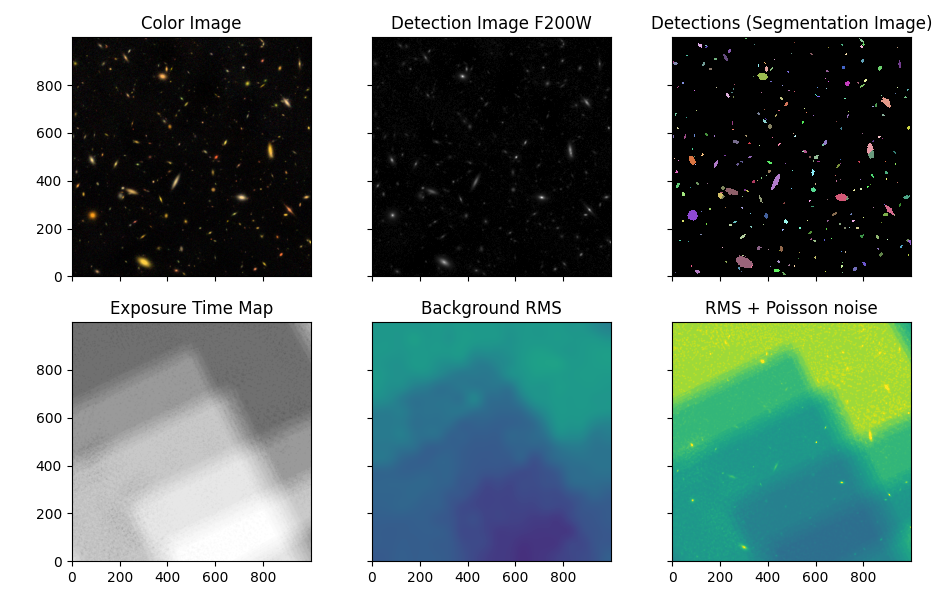

In [15]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9.5, 6))
# fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9.5, 6), subplot_kw={'projection': imwcs})
# For RA,Dec axes instead of pixels, add: , subplot_kw={'projection': imwcs})

# Color image
ax[0,0].imshow(color_image_short_wavelength, origin='lower')
ax[0,0].set_title('Color Image')

# Data
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0)
ax[0,1].imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax[0,1].set_title('Detection Image F200W')

# Segmentation map
cmap = detection_catalog.segm_deblend.make_cmap(seed=12345)  # ERROR
ax[0,2].imshow(detection_catalog.segm_deblend, origin='lower', cmap=cmap, interpolation='none')
ax[0,2].set_title('Detections (Segmentation Image)')

# norm = ImageNormalize(stretch=SqrtStretch())
# ax[1,0].imshow(weight, origin='lower', cmap='Greys_r', vmin=0)
# ax[1,0].set_title('Weight Image F200W')

ax[1,0].imshow(detection_catalog.exposure_time_map, origin='lower', cmap='Greys_r', vmin=0)
ax[1,0].set_title('Exposure Time Map')

# ax[1,0].imshow(background_map.background, origin='lower', cmap='Greys_r')
# ax[1,0].set_title('Background Pedestal')

# RMS
# norm = ImageNormalize()
vmin, vmax = 0.001, 0.0035
ax[1,1].imshow(detection_catalog.background_map.background_rms, origin='lower', vmin=vmin, vmax=vmax)
ax[1,1].set_title('Background RMS')

# Total error including Poisson noise
ax[1,2].imshow(detection_catalog.data_rms, origin='lower', vmin=vmin, vmax=vmax)
ax[1,2].set_title('RMS + Poisson noise')

fig.tight_layout()

print('Interactive zoom / pan controls all images simultaneously')

### View / save measured quantities in detection image (optional)

### Only keep some quantities

In [16]:
columns = 'label xcentroid ycentroid sky_centroid area semimajor_sigma semiminor_sigma'.split()
columns += 'ellipticity orientation gini'.split()
columns += 'kron_radius local_background segment_flux segment_fluxerr kron_flux kron_fluxerr'.split()
# columns += 'source_sum source_sum_err kron_flux kron_fluxerr kron_radius local_background'.split()

source_table = detection_catalog.catalog.to_table(columns=columns)
source_table.rename_column('semimajor_sigma', 'a')
source_table.rename_column('semiminor_sigma', 'b')

# Replace sky_centroid with ra, dec
source_table['ra'] = source_table['sky_centroid'].ra.degree * u.degree
source_table['dec'] = source_table['sky_centroid'].dec.degree * u.degree

columns = list(source_table.columns)
columns = columns[:3] + ['ra', 'dec'] + columns[4:-2]

source_table = source_table[columns]

In [17]:
# If interested, view / save output, but photometry in other filters will be added soon!
# source_table.write('JADES_detections.ecsv', overwrite=True)
# source_table.write('JADES_detections.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
# source_table

### Convert measured fluxes (data units) to magnitudes

https://docs.astropy.org/en/stable/units/

https://docs.astropy.org/en/stable/units/equivalencies.html#photometric-zero-point-equivalency

https://docs.astropy.org/en/stable/units/logarithmic_units.html#logarithmic-units

*Developer note:*
    
    flux units can be automatically converted to magnitude units
    but flux uncertainties *cannot* be automatically converted to magnitude uncertainties
    thus I wrote this function to do so
    
    Note magnitude uncertainties for detections should probably be u.mag instead of u.ABmag
    but magnitude uncertainties for non-detections quote u.ABmag upper limits
    They need to be the same, so we go with u.ABmag

In [18]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0 * u.ABmag, magerr)
    
    return mag, magerr

# Includes features I couldn't find in astropy:
# mag = 99 / -99 for non-detections / unobserved
# flux uncertainties -> mag uncertainties

### Multiband photometry using isophotal apertures defined in detection image
(Similar to running SourceExtractor in double-image mode)  
(No PSF corrections just yet)

In [19]:
# filters = 'F090W F200W F444W'.split()  # quicker for testing
for filt in filters:
    filter_catalog = Photutils_Catalog(filt)
    filter_catalog.measure_background_map()

    # Measure photometry in this filter for objects detected in detected image
    # segmentation map will define isophotal apertures
    filter_catalog.segm_deblend = detection_catalog.segm_deblend
    filter_catalog.measure_source_properties(exposure_time)
    
    # Convert measured fluxes to fluxes in nJy and to AB magnitudes
    filter_table = filter_catalog.catalog.to_table()
    source_table[filt+'_flux'] = flux = filter_table['segment_flux'] * filter_catalog.zeropoint.to(u.nJy)
    source_table[filt+'_fluxerr'] = fluxerr = filter_table['segment_fluxerr'] * filter_catalog.zeropoint.to(u.nJy)

    mag, magerr = fluxes2mags(flux, fluxerr)
    source_table[filt+'_mag'] = mag
    source_table[filt+'_magerr'] = magerr

F090W   zeropoint = 27.4525 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F090W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F090W_wht.fits


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


F115W   zeropoint = 27.5681 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F115W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F115W_wht.fits


F150W   zeropoint = 27.814 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F150W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F150W_wht.fits


F200W   zeropoint = 27.9973 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F200W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F200W_wht.fits


F277W   zeropoint = 27.8803 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F277W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F277W_wht.fits


F335M   zeropoint = 27.0579 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F335M.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F335M_wht.fits


F356W   zeropoint = 28.0068 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F356W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F356W_wht.fits


F410M   zeropoint = 27.1848 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F410M.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F410M_wht.fits


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


F444W   zeropoint = 28.0647 mag(AB)
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F444W_wht.fits


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Aperture corrections: isophotal to total (Kron aperture) fluxes

In [20]:
total_flux_table = deepcopy(source_table) # copy to new table, which will include total magnitude corrections

reference_flux_auto = total_flux_table['kron_flux']
reference_flux_iso = total_flux_table['segment_flux']
kron_flux_corrections = reference_flux_auto / reference_flux_iso
total_flux_table['total_flux_cor'] = kron_flux_corrections

for filt in filters:
    total_flux_table[filt+'_flux'] *= kron_flux_corrections
    total_flux_table[filt+'_fluxerr'] *= kron_flux_corrections
    # total_flux_table[filt+'_mag'] = total_flux_table[filt+'_flux'].to(u.ABmag)  # doesn't handle non-detections
    total_flux_table[filt+'_mag'] = fluxes2mags(total_flux_table[filt+'_flux'], total_flux_table[filt+'_fluxerr'])[0]
    # magnitude uncertainty magerr stays the same

### Reformat output catalog for readability (optional)

*Developer's Note:*

    'd' format incompatible with units (pix2)
    As a workaround, I set the format to '.0f' (a float with no decimals)

    ValueError: Unable to parse format string "d" for entry "101.0" in column "area"

In [21]:
isophotal_table = deepcopy(total_flux_table) # copy to new table, which will include PSF-corrections

old_columns = list(isophotal_table.columns)

# Reorder columns,
i = old_columns.index('segment_flux')
j = old_columns.index(filters[0]+'_flux')
columns = old_columns[:i] # detection catalog (except source_sum & kron_flux)
columns += old_columns[-1:]  # total_flux_cor
columns += old_columns[j:-1] # photometry in all filters
        
isophotal_table = isophotal_table[columns]

for column in columns:
    isophotal_table[column].info.format = '.4f'

isophotal_table['ra'].info.format = '11.7f'
isophotal_table['dec'].info.format = ' 11.7f'

isophotal_table['label'].info.format = 'd'
isophotal_table['area'].info.format = '.0f'  # 'd' raises error

### Isophotal Photometry without PSF corrections complete

We recommend proceeding with PSF corrections to photometry in the Long Wavelength Channel. But if you are interested, you may save the catalog now.

In [22]:
# isophotal_table.write('JADES_isophotal_photometry.ecsv', overwrite=True)
# isophotal_table.write('JADES_isophotal_photometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
# isophotal_table

## PSF magnitude corrections

Color corrections are perfomed as described here:
https://www.stsci.edu/~dcoe/ColorPro/color

Note this is different from one common approach, which is to degrade every image to the broadest PSF.

Photometry is only corrected in Long Wavelength images > 2.4 microns. The F200W detection image is convolved (blurred) to the PSF of each Long Wavelength image. Then we correct colors based on the magnitudes lost in that aperture:

* PSF_magnitude_corrections = detection_image_magnitudes - blurred_detection_image_magnitudes

In practice, we actually correct the fluxes:

* PSF_flux_corrections = detection_image_fluxes / blurred_detection_image_fluxes

### Load PSFs

PSF files used in this notebook were extracted from tar files available on JDox:  
https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-SimulatedNIRCamPSFs  
PSFs_SW_filters (short wavelength channel): https://stsci.box.com/s/s2lepxr9086gq4sogr3kwftp54n1c5vl  
PSFs_LW_filters (long wavelength channel): https://stsci.box.com/s/gzl7blxb1k3p4n66gs7jvt7xorfrotyb  

Each FITS file contains:  
– hdu[0]: a 4x oversampled PSF  
– hdu[1]: PSF at detector pixel scale (0.031" and 0.063" in the short and long wavelength channels, respectively)  
This notebook will use the latter: PSF at detector pixel scale. We find no advantage to the former for this notebook.

In [23]:
PSF_inputs = {}
PSF_images = {}

detector_pixel_scales = {'SW': 0.031, 'LW': 0.063}

PSF_url = os.path.join(input_file_url, 'NIRCam_PSFs')

for i, filt in enumerate(filters):
    lam = wavelengths[i]
    if lam < 2.4 * u.um:
        channel = 'SW'  # Short Wavelength Channel < 2.4 microns
    else:
        channel = 'LW'  # Long Wavelength Channel > 2.4 microns

    # Load PSF
    PSF_file = 'PSF_%scen_G5V_fov299px_ISIM41.fits' % filt
    # PSF_file = os.path.join('NIRCam_PSFs_' + channel, PSF_file)
    PSF_file = os.path.join(PSF_url, PSF_file)

    print(PSF_file)
    PSF_hdu = fits.open(PSF_file)
    PSF_inputs[filt] = data = PSF_hdu[1].data  # extension [1] is at pixel scale (not oversampled)
    ny, nx = data.shape
    
    # Resize from detector pixel scale to image pixel scale (here 0.03" / pix)
    detector_pixel_scale = detector_pixel_scales[channel]
    ny_resize = ny * detector_pixel_scale / image_pixel_scale  # Assume square PSF (ny = nx)
    ny_resize = np.round(ny_resize)
    ny_resize = int((ny_resize // 2) * 2 + 1)  # Make it an odd number of pixels to ensure PSF is centered
    PSF_pixel_scale = ny_resize / ny * image_pixel_scale    
    PSF_image = resize_psf(PSF_inputs[filt], PSF_pixel_scale, image_pixel_scale)  # Resize PSF here
    r = (ny_resize - ny) // 2
    PSF_images[filt] = PSF_image[r:-r, r:-r]  # Trim to same size as input PSFs
    # Note PSF is no longer normalized but will be later in convolution step
    # print(filt, ny, ny_resize, PSF_image.shape, PSF_images[filt].shape, PSF_pixel_scale)

https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F090Wcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F115Wcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F150Wcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F200Wcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F277Wcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F335Mcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F356Wcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F410Mcen_G5V_fov299px_ISIM41.fits


https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/PSF_F444Wcen_G5V_fov299px_ISIM41.fits


In [24]:
np.sum(PSF_images[filt])

np.float64(0.9857464993548493)

In [25]:
np.sum(PSF_image[r:-r, r:-r])

np.float64(0.9857464993548493)

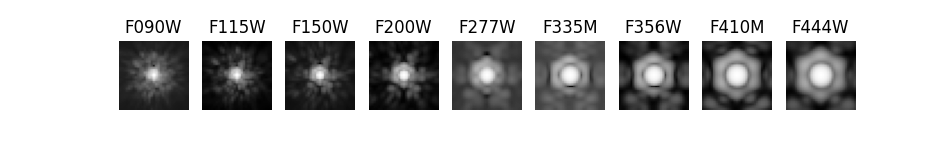

In [26]:
# Show PSFs (optional)

fig, ax = plt.subplots(1, len(filters), figsize=(9.5, 1.5), sharex=True, sharey=True)

r = 15  # PSF will be shown out to radius r (pixels)
for i, filt in enumerate(filters):
    data = PSF_images[filt]
    ny, nx = data.shape
    yc = ny // 2
    xc = nx // 2
    stamp = data[yc-r:yc+r+1, xc-r:xc+r+1]
    norm = ImageNormalize(stretch=LogStretch())  # scale each filter individually
    ax[i].imshow(stamp, cmap='Greys_r', norm=norm, origin='lower')
    ax[i].set_title(filt.upper())
    ax[i].axis('off')

## PSF Matching 

https://photutils.readthedocs.io/en/stable/psf_matching.html

### Determine PSF convolution kernels

In [27]:
PSF_kernels = {}
reference_filter = 'F200W'
reference_PSF = PSF_images[reference_filter]
i_reference = filters.index(reference_filter)
window = SplitCosineBellWindow(alpha=0.35, beta=0.3)
for filt in filters[i_reference+1:]:
    PSF_kernels[filt] = create_matching_kernel(reference_PSF, PSF_images[filt], window=window)

## Convolve F200W detection image to Long Wavelength PSFs

In [28]:
reference_image_hdu = fits.open(image_files[reference_filter])
reference_image_data = reference_image_hdu[0].data[:]

for output_filter in filters[i_reference+1:]:
    output_image = 'jades_convolved_%s_to_%s.fits' % (reference_filter, output_filter)
    if os.path.exists(output_image):
        print(output_image, 'EXISTS')
    else:
        print(output_filter + '...')
        PSF_kernel = PSF_kernels[output_filter][yc-r:yc+r+1, xc-r:xc+r+1]
        # convolve_fft may be faster for larger images / kernels (but doesn't make much difference in this demo):
        convolved_image = convolve(reference_image_data, PSF_kernel, normalize_kernel=True)
        reference_image_hdu[0].data = convolved_image
        print('SAVING %s' % output_image)
        reference_image_hdu.writeto(output_image)

F277W...


SAVING jades_convolved_F200W_to_F277W.fits
F335M...


SAVING jades_convolved_F200W_to_F335M.fits
F356W...


SAVING jades_convolved_F200W_to_F356W.fits
F410M...


SAVING jades_convolved_F200W_to_F410M.fits
F444W...


SAVING jades_convolved_F200W_to_F444W.fits


### Multiband photometry in convolved images

In [29]:
# Measure and save the fluxes in each blurry image
blurry_catalog = QTable()

for blurry_filter in filters[i_reference+1:]:
    image_file = 'jades_convolved_%s_to_%s.fits' % (reference_filter, blurry_filter)
    filter_catalog = Photutils_Catalog(blurry_filter, image_file=image_file)
    filter_catalog.measure_background_map()

    # Measure photometry in this filter for objects detected in detected image
    # segmentation map will define isophotal apertures
    filter_catalog.segm_deblend = detection_catalog.segm_deblend
    filter_catalog.measure_source_properties(exposure_time)

    # Convert measured fluxes to fluxes in nJy
    filter_table = filter_catalog.catalog.to_table()
    blurry_catalog[blurry_filter+'_flux'] = filter_table['segment_flux'] * filter_catalog.zeropoint.to(u.nJy)

F277W   zeropoint = 27.9973 mag(AB)
jades_convolved_F200W_to_F277W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F277W_wht.fits


F335M   zeropoint = 27.9973 mag(AB)
jades_convolved_F200W_to_F335M.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F335M_wht.fits


F356W   zeropoint = 27.9973 mag(AB)
jades_convolved_F200W_to_F356W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F356W_wht.fits


F410M   zeropoint = 27.9973 mag(AB)
jades_convolved_F200W_to_F410M.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F410M_wht.fits


F444W   zeropoint = 27.9973 mag(AB)
jades_convolved_F200W_to_F444W.fits
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/jades_jwst_nircam_goods_s_crop_F444W_wht.fits


### PSF magnitude corrections

https://www.stsci.edu/~dcoe/ColorPro/color

In [30]:
PSF_corrected_table = deepcopy(isophotal_table)

reference_fluxes = PSF_corrected_table[reference_filter+'_flux']  # det_flux_auto

for filt in filters[i_reference+1:]:
    # Convert isophotal fluxes to total fluxes
    blurry_total_fluxes = blurry_catalog[filt+'_flux'] * kron_flux_corrections
    PSF_flux_corrections = reference_fluxes / blurry_total_fluxes
    PSF_corrected_table[filt+'_flux'] *= PSF_flux_corrections
    PSF_corrected_table[filt+'_fluxerr'] *= PSF_flux_corrections
    # PSF_corrected_table[filt+'_mag'] = PSF_corrected_fluxes.to(u.ABmag)  # doesn't handle non-detections
    PSF_corrected_table[filt+'_mag'], PSF_corrected_table[filt+'_magerr'] = \
        fluxes2mags(PSF_corrected_table[filt+'_flux'], PSF_corrected_table[filt+'_fluxerr'])
    PSF_corrected_table[filt+'_PSF_flux_cor'] = PSF_flux_corrections    

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [31]:
PSF_corrected_table.write('JADES_photometry.ecsv', overwrite=True)
PSF_corrected_table.write('JADES_photometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [32]:
# PSF_corrected_table

In [33]:
# !cat JADES_photometry.cat

## Start new session and analyze results

Just run the first few blocks above, including imports, defining file lists, and creating the color image

### Load catalog and segmentation map

In [34]:
# Catalog: ecsv format preserves units for loading in Python notebooks
output_catalog = QTable.read('JADES_photometry.ecsv')

In [35]:
# Reconstitute filter list
filters = []
for param in output_catalog.columns:
    if param[-4:] == '_mag':
        filters.append(param[:-4])

In [36]:
# Segmentation map
segmfile = 'JADES_detections_segm.fits'
segm = fits.open(segmfile)[0].data
segm = SegmentationImage(segm)

## Input simulation JADES JAGUAR catalog

In [37]:
# full_catalog_file = 'JADES_SF_mock_r1_v1.1.fits.gz'  # not available in this demo
# Cropped 302,515 simulated galaxies down to 653 in the smaller image region used in this demo
cropped_catalog_file = 'JADES_SF_mock_r1_v1.1_crop.fits.gz'
input_catalog_file = os.path.join(input_file_url, cropped_catalog_file)
simulated_catalog = Table.read(input_catalog_file)

### Match objects to photutils catalog

https://docs.astropy.org/en/stable/coordinates/matchsep.html

In [38]:
input_coordinates = SkyCoord(ra=simulated_catalog['RA']*u.degree, dec=simulated_catalog['DEC']*u.degree)

# Can use output_catalog['sky_centroid'] if saved in table, but this demo saved (ra,dec) instead:
detected_coordinates = SkyCoord(ra=output_catalog['ra'], dec=output_catalog['dec'])

# Match photutils detection sources to input object catalog:
input_indices, separation2d, distance3d = detected_coordinates.match_to_catalog_sky(input_coordinates)

Determine threshold maximum distance between input objects and matched output sources

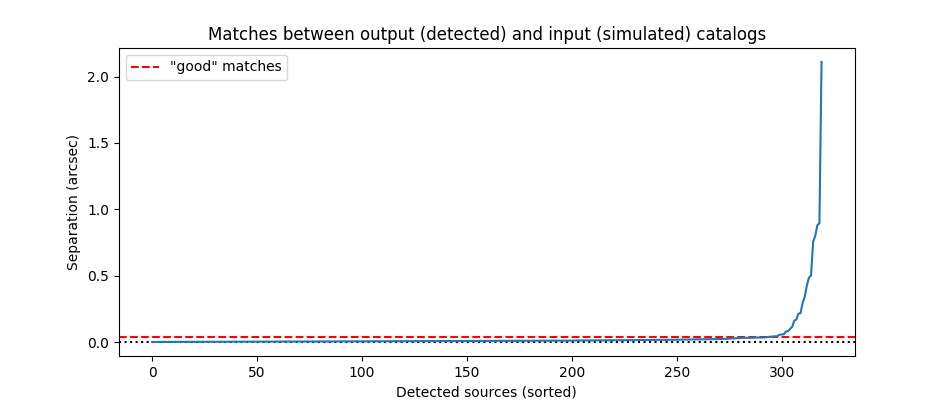

In [39]:
fig = plt.figure(figsize=(9.5, 4))
plt.plot(np.sort(separation2d.to(u.arcsec)), zorder=10)
separation_max = 0.036 * u.arcsec  # determined by eye after plotting
plt.axhline(0, c='k', ls=':')
plt.axhline(separation_max.value, c='r', ls='--', label='"good" matches')
plt.title('Matches between output (detected) and input (simulated) catalogs')
plt.xlabel('Detected sources (sorted)')
plt.ylabel('Separation (arcsec)')
plt.legend()

In [40]:
good_matches = separation2d < separation_max
unique_matches, index_counts = np.unique(input_indices[good_matches], return_counts=True)

print('%d matches (%d unique) between input catalog (%d galaxies) and photutils catalog (%d detected sources)'
      % (np.sum(good_matches), len(unique_matches), len(simulated_catalog), len(output_catalog)))

multiple_matches = unique_matches[index_counts > 1]
if len(multiple_matches):
    print('Input sources matched multiple times:', list(output_catalog['id'][multiple_matches]))

293 matches (293 unique) between input catalog (653 galaxies) and photutils catalog (320 detected sources)


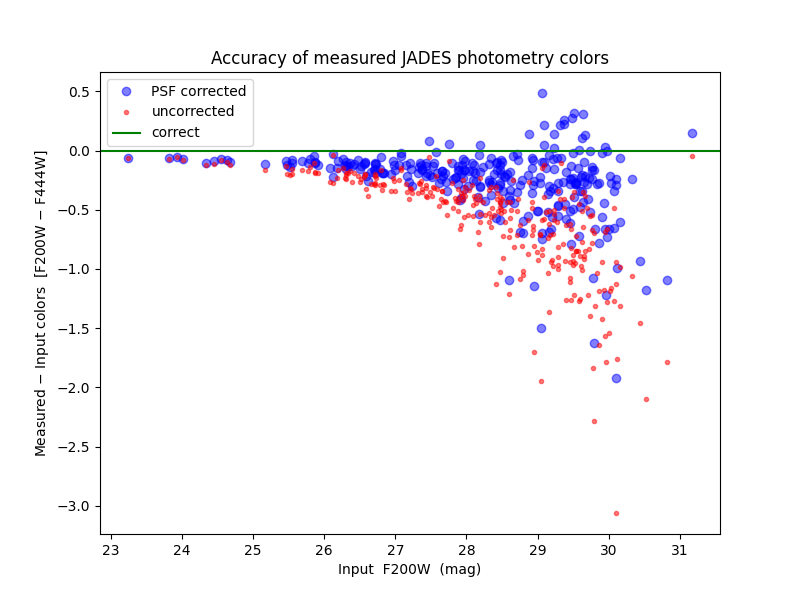

In [41]:
# Input vs. Output Color

filt1, filt2 = 'F200W F444W'.split()

input_flux1 = simulated_catalog['NRC_%s_fnu' % filt1][input_indices][good_matches]
input_flux2 = simulated_catalog['NRC_%s_fnu' % filt2][input_indices][good_matches]

input_mag1 = (input_flux1 * u.nJy).to(u.ABmag).value
input_mag2 = (input_flux2 * u.nJy).to(u.ABmag).value

output_mag1 = output_catalog[filt1 + '_mag'][good_matches].value
output_mag2 = output_catalog[filt2 + '_mag'][good_matches].value
output_ids = output_catalog['label'][good_matches].data.astype(int)

# Only plot detections
det1 = (0 < output_mag1) & (output_mag1 < 90)
det2 = (0 < output_mag2) & (output_mag2 < 90)
det = det1 * det2

output_mag1 = output_mag1[det]
output_mag2 = output_mag2[det]

input_color = input_mag1 - input_mag2
output_color = output_mag1 - output_mag2

output_mag1_uncor = output_mag1
PSF_flux_cor = output_catalog[filt2+'_PSF_flux_cor']
PSF_mag_cor = -2.5 * np.log10(PSF_flux_cor)
output_mag2_uncor = output_mag2 - PSF_mag_cor[good_matches][det].value
output_color_uncor = output_mag1_uncor - output_mag2_uncor

plt.figure(figsize=(8, 6))

plt.plot(input_mag1, output_color - input_color, 'bo', alpha=0.5, label='PSF corrected')
plt.plot(input_mag1, output_color_uncor - input_color, 'r.', alpha=0.5, label='uncorrected')

plt.axhline(0, c='g', label='correct')
plt.xlabel('Input  ' + filt1 + '  (mag)')
plt.ylabel('Measured $-$ Input colors  [%s $-$ %s]' % (filt1, filt2))
plt.title('Accuracy of measured JADES photometry colors')

plt.legend();
# plt.savefig('JADES_color_deviation_%s-%s.png' % (filt1, filt2))

### Plot F200W vs. F090W magnitudes and look for dropouts

Hover cursor over data point to reveal magnitudes and catalog ID number


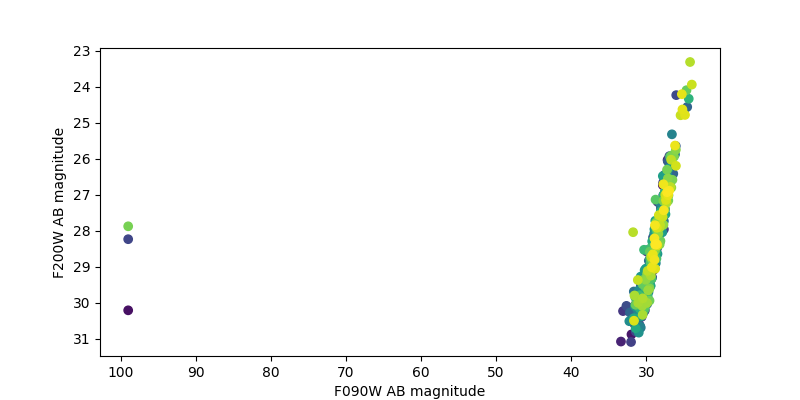

In [42]:
mag1 = output_catalog['F090W_mag']
mag2 = output_catalog['F200W_mag']

# Only plot detections in F200W
det2 = (0*u.ABmag < mag2) & (mag2 < 90*u.ABmag)

mag1 = mag1[det2]
mag2 = mag2[det2]
ids = output_catalog['label'][det2].data.astype(int)

plt.figure(figsize=(8, 4))

plt.scatter(mag1, mag2, c=ids)

plt.xlabel('F090W AB magnitude')
plt.ylabel('F200W AB magnitude')

plt.xlim(plt.xlim()[::-1])  # brighter at right
plt.ylim(plt.ylim()[::-1])  # brighter at top

mplcursors.cursor(hover=mplcursors.HoverMode.Transient)
print('Hover cursor over data point to reveal magnitudes and catalog ID number')

In [43]:
# Select brightest F090W dropout
dropouts = output_catalog['F090W_mag'] > 90 * u.ABmag
i_brightest_dropout = output_catalog[dropouts]['F200W_mag'].argmin()
output_id = output_catalog[dropouts][i_brightest_dropout]['label']
output_id

np.int32(254)

In [44]:
# Select object with id from catalog
output_index = segm.get_index(output_id)
output_obj = output_catalog[output_index]
segmobj = segm.segments[segm.get_index(output_id)]
print(output_id, output_obj['F090W_mag'], output_obj['F200W_mag'])

254 99.0 mag(AB) 27.87690053269815 mag(AB)


In [45]:
# Alternartively, could select an object by position
# x, y = 905, 276
# id = segm.data[y,x]

### Show selected object in all filters

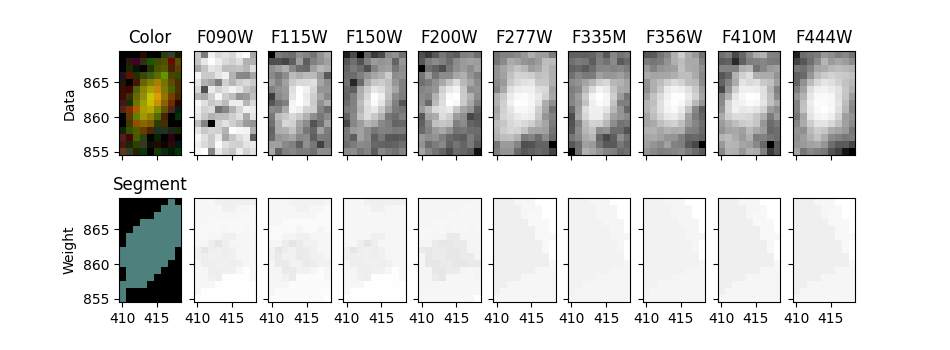

In [46]:
fig, ax = plt.subplots(2, len(filters)+1, figsize=(9.5, 3.5), sharex=True, sharey=True)

ax[0, 0].imshow(color_image_short_wavelength[segmobj.slices], origin='lower', extent=segmobj.bbox.extent)
ax[0, 0].set_title('Color')

cmap = segm.make_cmap(seed=12345)  # ERROR
ax[1, 0].imshow(segm.data[segmobj.slices], origin='lower', extent=segmobj.bbox.extent, cmap=cmap,
                interpolation='nearest')
ax[1, 0].set_title('Segment')

for i in range(1, len(filters)+1):
    filt = filters[i-1]

    # Show data on top row
    data = fits.open(image_files[filt])[0].data
    stamp = data[segmobj.slices]
    norm = ImageNormalize(stretch=SqrtStretch())  # scale each filter individually
    ax[0, i].imshow(stamp, extent=segmobj.bbox.extent, cmap='Greys_r', norm=norm, origin='lower')
    ax[0, i].set_title(filt.upper())

    # Show weights on bottom row
    weight = fits.open(weight_files[filt])[0].data
    stamp = weight[segmobj.slices]
    # set black to zero weight (no exposure time / bad pixel)
    ax[1, i].imshow(stamp, extent=segmobj.bbox.extent, vmin=0, cmap='Greys_r', origin='lower')

ax[0, 0].set_ylabel('Data')
ax[1, 0].set_ylabel('Weight');

## Plot Spectral Energy Distribution (SED) for one object

In [47]:
# output_obj = output_catalog[index]  # already done above
input_obj = simulated_catalog[input_indices][output_index]

In [48]:
input_fluxes = np.array([input_obj['NRC_%s_fnu' % filt] for filt in filters])
output_fluxes = np.array([output_obj[filt+'_flux'].value for filt in filters])
output_flux_errs = np.array([output_obj[filt+'_fluxerr'].value for filt in filters])

In [49]:
# Measured flux does not recover total input flux
# Given known simulation input, determine what fraction of the flux was recovered
# Use this to scale measured SED to input SED for comparison, plotted below

# Scale output to input flux using F200W only (other filters may have incorrect flux corrections)

filt = 'F200W'
flux_scale_factor = output_obj[filt+'_flux'].value / input_obj['NRC_%s_fnu' % filt]
flux_factor = 1 / flux_scale_factor  # input / output
print('%d%% of input flux recovered by photutils' % (100 * flux_scale_factor))

71% of input flux recovered by photutils


In [50]:
if 0:
    # Scale output to input flux considering all measured fluxes and uncertainties
    # Benitez+00 Equations 8 & 9
    FOT = np.sum(input_fluxes * output_fluxes / output_flux_errs**2)
    FTT = np.sum(input_fluxes**2 / output_flux_errs**2)
    flux_scale_factor = FOT / FTT  # a_m: observed / theoretical (output / input)
    flux_factor = 1 / flux_scale_factor  # input / output
    print('%d%% of input flux recovered by photutils' % (100 * flux_scale_factor))

In [51]:
PSF_flux_corrections = np.ones(len(filters))
for i, filt in enumerate(filters):
    PSFcor_column = filt+'_PSF_flux_cor'
    if PSFcor_column in list(output_obj.columns):
        PSF_flux_corrections[i] = output_obj[PSFcor_column]

PSF_flux_corrections

array([1.        , 1.        , 1.        , 1.        , 1.03502198,
       1.0817409 , 1.0888273 , 1.1281779 , 1.1542393 ])

*Developer's Note:*

    automatic secondary axis magnitudes don't work when fluxes extend to negative values
    so I wrote my own code to do this

In [52]:
def add_magnitude_axis(ax, flux_units=u.nJy, plothuge=True):
    ylo, yhi = plt.ylim() * flux_units
    maghi = yhi.to(u.ABmag).value
    ytx1 = np.ceil(maghi * 10) / 10.  # 24.101 -> 24.2
    ytx2 = np.ceil(maghi)  # 24.1 -> 25

    fpart = ytx1 - int(ytx1)  # 0.2
    if np.isclose(fpart, 0) or np.isclose(fpart, 0.9):
        ytx1 = []
    elif np.isclose(fpart, 0.1) or np.isclose(fpart, 0.2):
        ytx1 = np.array([ytx1, ytx2-0.7, ytx2-0.5, ytx2-0.3])  # 24.1, 24.3, 24.5, 24.7
    elif np.isclose(fpart, 0.3) or np.isclose(fpart, 0.4):
        ytx1 = np.array([ytx1, ytx2-0.5, ytx2-0.3])  # 24.3, 24.5, 24.7
    elif np.isclose(fpart, 0.5):
        ytx1 = np.array([ytx1, ytx2-0.3])  # 24.5, 24.7
    elif np.isclose(fpart, 0.6):
        ytx1 = np.array([ytx1, ytx2-0.2])  # 24.6, 24.8

    if isinstance(ytx1, float):
        ytx1 = np.array([ytx1])

    if plothuge:
        ytx3 = ytx2 + np.array([0, 0.2, 0.5, 1, 2])
    else:
        ytx3 = ytx2 + np.array([0, 0.2, 0.5, 1, 1.5, 2, 3])

    ytx2 = np.array([ytx2])
    ytx = np.concatenate([ytx1, ytx3])
    yts = ['%g' % mag for mag in ytx]

    ytx = (ytx * u.ABmag).to(flux_units).value
    
    ax2 = ax.twinx()
    ax.yaxis.set_label_position('left')
    ax2.yaxis.set_label_position('right')
    ax.yaxis.tick_left()
    ax2.yaxis.tick_right()

    ax2.set_yticks(ytx)
    ax2.set_yticklabels(yts)
    ax2.set_ylabel('Magnitude (AB)')
    ax2.set_ylim(ylo.value, yhi.value)
    ax2.set_zorder(-100)  # interactive cursor will output left axis ax

*Developer's Note:*

    errorbar doesn't work with units either

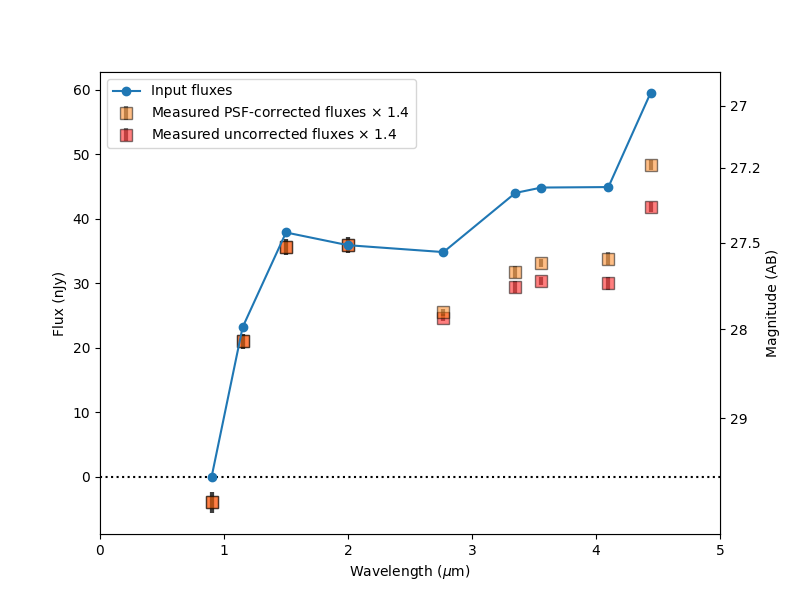

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(wavelengths, input_fluxes, 'o-', label='Input fluxes', zorder=10)

label = 'Measured PSF-corrected fluxes $\\times$ %.1f' % flux_factor
plt.errorbar(wavelengths.value, output_fluxes * flux_factor, output_flux_errs * flux_factor,
             ms=8, marker='s', mfc=mpl_colors[1], c='k', lw=3, alpha=0.5, ls='none', label=label)

label = 'Measured uncorrected fluxes $\\times$ %.1f' % flux_factor
plt.errorbar(wavelengths.value, output_fluxes * flux_factor / PSF_flux_corrections, output_flux_errs * flux_factor,
             ms=8, marker='s', mfc='r', c='k', lw=3, alpha=0.5, ls='none', label=label, zorder=-10)

plt.legend()
plt.axhline(0, c='k', ls=':')
plt.xlim(0, 5)
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('Flux (nJy)')
add_magnitude_axis(ax)

plt.savefig('JADES photutils SED linear.png')

*Developer's Notes:*

    Ideally, the secondary axis should know how to convert between units.
    As a workaround, I wrote functions and fed them in.

    Even then, this only works so long as fluxes are positive.
    Clipping all fluxes to positive values doesn't work either.

    I would like to automatically scale the y limits to only *some* of the plotted data along the lines of:
    https://stackoverflow.com/questions/7386872/make-matplotlib-autoscaling-ignore-some-of-the-plots
    But that old solution didn't work.
    So for now, I just hard-coded a range that works for this object: y=10-70.

Text(0.5, 1.0, 'JADES SED PSF-corrected')

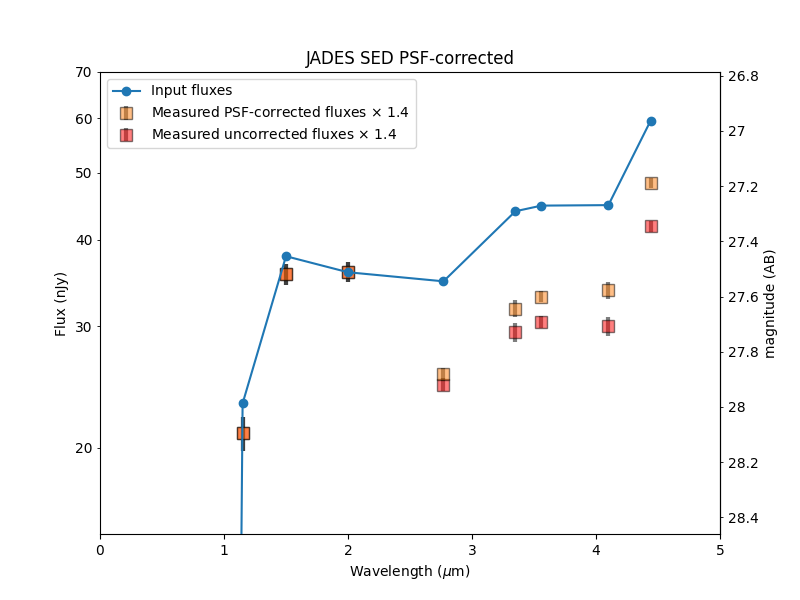

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))

if 0:  # this didn't work
    ax.autoscale(True)
    detections = output_fluxes > 0
    ax.plot(wavelengths[detections], output_fluxes[detections] * flux_factor, visible=False)
    ax.autoscale(False)

plt.plot(wavelengths, input_fluxes, 'o-', label='Input fluxes', zorder=10, scaley=False)

label = 'Measured PSF-corrected fluxes $\\times$ %.1f' % flux_factor
plt.errorbar(wavelengths.value, output_fluxes * flux_factor, output_flux_errs * flux_factor,
             ms=8, marker='s', mfc=mpl_colors[1], c='k', lw=3, alpha=0.5, ls='none', label=label)

label = 'Measured uncorrected fluxes $\\times$ %.1f' % flux_factor
plt.errorbar(wavelengths.value, output_fluxes * flux_factor / PSF_flux_corrections, output_flux_errs * flux_factor,
             ms=8, marker='s', mfc='r', c='k', lw=3, alpha=0.5, ls='none', label=label, zorder=-10)

plt.legend()
plt.axhline(0, c='k', ls=':')
plt.xlim(0, 5)
plt.ylim(15, 70)
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('Flux (nJy)')
plt.semilogy()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))

# Add AB magnitudes as secondary x-axis at right
# (Note this breaks if any fluxes are negative)
# https://matplotlib.org/gallery/subplots_axes_and_figures/secondary_axis.html#sphx-glr-gallery-subplots-axes-and-figures-secondary-axis-py

def AB2nJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.nJy)
    return f.value

def nJy2AB(F_nJy):
    f = F_nJy * u.nJy
    m = f.to(u.ABmag)
    return m.value

# secondary_axis = add_magnitude_axis(ax, flux_units)
secax = ax.secondary_yaxis('right', functions=(nJy2AB, AB2nJy))
secax.set_ylabel('magnitude (AB)')
secax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
secax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))

plt.title('JADES SED PSF-corrected')
# plt.savefig('JADES photutils SED.png')